# 訪日旅行中の行動志向分析 ― 主成分分析によるインバウンド行動構造の把握 ―

### 目的とアジェンダ

#### 分析の目的
本分析では、訪日外国人旅行者が旅行中に実施した行動内容に着目し、多数の行動項目間に存在する相関構造を主成分分析（PCA）によって整理することで、訪日旅行者の行動特性を構造的に把握することを目的とする。

訪日旅行中の行動は、文化体験、娯楽、自然観光、買物、宿泊、レジャーなど多岐にわたり、個別項目の単純集計のみでは、旅行者がどのような志向性や行動様式を持っているのかを十分に捉えることが難しい。
そこで本分析では、行動項目間の関係性に注目し、訪日旅行者の行動を規定する潜在的な志向軸（行動特性）を抽出・要約する。

具体的には、主成分分析を通じて、

・  訪日旅行者が何に強い関心を持っているのか  
・  どのような旅行スタイルで行動しているのか  
・  都市型観光と自然・地方観光のいずれを主な舞台としているのか  

といった観点から、訪日旅行行動を整理することを目指す。

本Notebookは、こうして抽出された主成分の解釈・命名を通じて、インバウンド市場の行動構造を理解するための基礎的な枠組みを提示するものであり、後続の国別分析や時系列分析における共通の分析軸を構築することを目的としている。

#### 主要な分析ステップ

1.  主成分分析（PCA）の実行と主成分数の決定
2.  主成分の解釈および命名

### 環境構築とデータ準備
訪日旅行中の行動項目データの確認と分析単位および標準化処理の方針を整理する。

In [1]:
# ==============================================================================
# 分析の概要とデータ準備
# ==============================================================================

### ライブラリのインポート
import pandas as pd
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

# 日本語表示のための設定 
try:
    import japanize_matplotlib
    plt.rcParams['font.size'] = 12
except ImportError:
    # !pip install japanize-matplotlib
    print(" 日本語表示のため、'pip install japanize-matplotlib'を実行し、Notebookを再起動することを推奨します。")

### 定数の設定
DATA_PATH = '../data/'
DATA_FILENAME = 'inbound_action.csv'

COUNTRY_AREA_COL = 'Country/Area'
ACTION_COL = 'Action' 
YEAR_COL = 'Year'
VALUE_COL = 'Composition ratio' 

# 分析から除外する項目
ACTION_TO_EXCLUDE = '上記には当てはまるものがない'
COUNTRY_AREA_TO_EXCLUDE = '全国籍・地域'
TARGET_YEAR = 2024 # 最新年を対象とする

### データの読み込み、フィルタリング、整形

# データの読み込み
df = pd.read_csv(os.path.join(DATA_PATH, DATA_FILENAME))

# フィルタリング (対象年、除外項目)
df_filtered = df[df[COUNTRY_AREA_COL] != COUNTRY_AREA_TO_EXCLUDE].copy()
df_filtered = df_filtered[df_filtered[ACTION_COL] != ACTION_TO_EXCLUDE].copy()
df_filtered = df_filtered[df_filtered[YEAR_COL] == TARGET_YEAR].copy()

# PIVOT (PCA用のデータ形式に整形: [国・地域] x [行動])
df_pivot = df_filtered.pivot(index=COUNTRY_AREA_COL, columns=ACTION_COL, values=VALUE_COL)

# 欠損値（NaN）の確認と補完
df_pivot = df_pivot.fillna(0)


# ==============================================================================
# データ標準化
# ==============================================================================
print("\n--- データ標準化 ---")

# データの標準化 (平均0、分散1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_pivot)
X_scaled_df = pd.DataFrame(X_scaled, index=df_pivot.index, columns=df_pivot.columns)

print("データ準備と標準化が完了しました。")


--- データ標準化 ---
データ準備と標準化が完了しました。


### 1. 主成分分析（PCA）の実行と主成分数の決定

訪日観光客の「旅行中の行動内容」に関する多数の行動項目間の相関構造にもとづく主成分を抽出し、寄与率および累積寄与率を確認する。  
そこから、解釈可能性および実務的有用性を踏まえて主成分数を選定する。

#### 寄与率と累積寄与率

Principal Component,Explained Variance Ratio (寄与率),Cumulative Explained Variance (累積寄与率)
PC1,0.4228,0.4228
PC2,0.1753,0.5981
PC3,0.0927,0.6908
PC4,0.0725,0.7633
PC5,0.0549,0.8182



 累積寄与率が80%を超えるのは **5** 個の主成分です。


#### スクリープロット（主成分数決定の根拠）

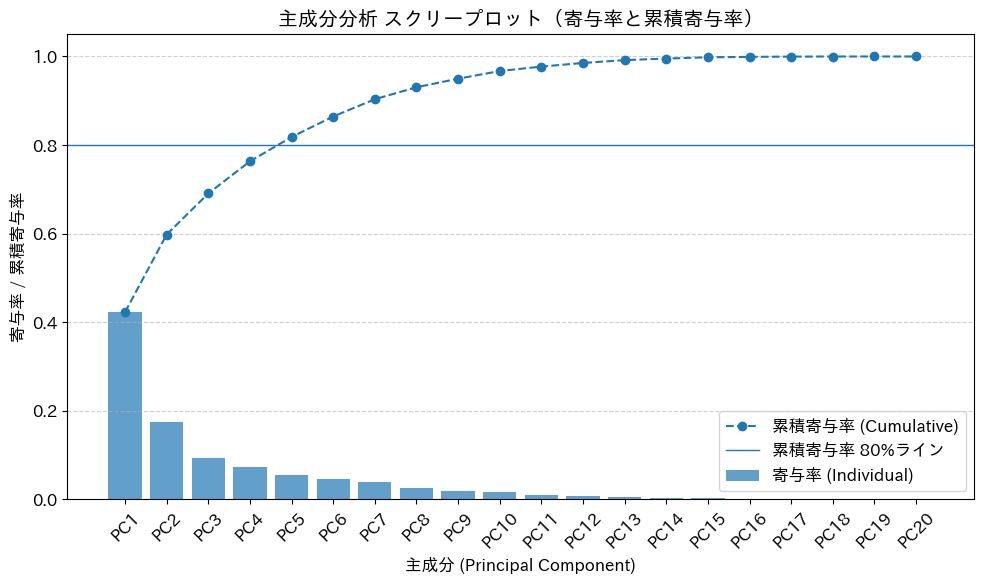

#### PC1〜PC5：強い主成分負荷量（0.3以上）件数と集中度

主成分,主成分負荷量0.3以上の項目数,寄与率,上位3項目集中度（Top3/Total）,集中度（HHI）
PC1,4,0.422800,0.231400,0.059500
PC2,4,0.175300,0.344300,0.083900
PC3,4,0.092700,0.384000,0.080600
PC4,4,0.072500,0.335700,0.073700
PC5,5,0.054900,0.383500,0.088800


- **主成分負荷量0.3以上の項目数**：その主成分を強く特徴づける項目の多さの目安
- **集中度（Top3/Total, HHI）**：少数項目に依存している度合いの目安（高いほど“偏り”が強い）
- ※本分析では回転（Varimax等）は行っていないため、一部主成分で負荷が分散し解釈が曖昧になる場合がある

#### PC1〜PC5：主成分負荷量0.3以上 の項目一覧

#### PC1（寄与率: 42.28%）

Action,PC1,PC2,PC3,PC4,PC5
日本の歴史・伝統文化体験,0.324200,0.063700,-0.112900,-0.107800,-0.088200
美術館・博物館・動植物園・水族館,0.313100,0.033800,-0.038400,-0.115100,0.140100
日本の日常生活体験,0.311100,0.074200,-0.088700,-0.137100,-0.124500
日本のポップカルチャーを楽しむ,0.305300,-0.088100,-0.184500,0.104500,0.001300


#### PC2（寄与率: 17.53%）

Action,PC1,PC2,PC3,PC4,PC5
テーマパーク,0.027200,0.447000,-0.067400,0.304700,-0.006900
四季の体感（花見・紅葉・雪等）,0.066300,0.394200,0.139100,-0.311600,0.073700
ショッピング,-0.100800,0.347400,-0.132100,0.431700,0.012100
温泉入浴,0.184700,-0.308800,0.088900,-0.004100,0.340100


#### PC3（寄与率: 9.27%）

Action,PC1,PC2,PC3,PC4,PC5
スキー・スノーボード,0.048800,0.176400,0.524200,0.042700,0.489400
その他スポーツ（ゴルフ等）,0.179000,-0.019300,0.502200,0.270400,-0.133700
スポーツ観戦（相撲・サッカー等）,0.286100,0.007500,0.303600,0.058400,-0.154100
映画・アニメゆかりの地を訪問,0.262600,-0.004400,-0.326100,0.202000,-0.007900


#### PC4（寄与率: 7.25%）

Action,PC1,PC2,PC3,PC4,PC5
日本食を食べること,0.116300,-0.165200,0.058200,0.492900,0.207300
ショッピング,-0.100800,0.347400,-0.132100,0.431700,0.012100
テーマパーク,0.027200,0.447000,-0.067400,0.304700,-0.006900
四季の体感（花見・紅葉・雪等）,0.066300,0.394200,0.139100,-0.311600,0.073700


#### PC5（寄与率: 5.49%）

Action,PC1,PC2,PC3,PC4,PC5
スキー・スノーボード,0.048800,0.176400,0.524200,0.042700,0.489400
温泉入浴,0.184700,-0.308800,0.088900,-0.004100,0.340100
旅館に宿泊,0.216200,-0.299800,-0.229200,-0.091200,0.305900
舞台・音楽鑑賞,0.260000,-0.005100,0.035200,0.120400,-0.333000
治療・検診,0.203600,-0.000700,0.134800,-0.059900,-0.457200


In [29]:
# ----------------------------
# PCA実行
# ----------------------------
pca = PCA()
pca.fit(X_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

variance_df = pd.DataFrame({
    "Principal Component": [f"PC{i+1}" for i in range(len(explained_variance_ratio))],
    "Explained Variance Ratio (寄与率)": explained_variance_ratio,
    "Cumulative Explained Variance (累積寄与率)": cumulative_variance_ratio
})

# 80%到達までの主成分数
num_components_80 = int(np.where(cumulative_variance_ratio >= 0.8)[0][0] + 1)

# ----------------------------
# 寄与率・累積寄与率（表）+ スクリープロット
# ----------------------------
display(Markdown("#### 寄与率と累積寄与率"))
display(
    variance_df.head(num_components_80)
    .style.format({
    "Explained Variance Ratio (寄与率)": "{:.4f}",
    "Cumulative Explained Variance (累積寄与率)": "{:.4f}"
    })
    .hide(axis="index")
)
print(f"\n 累積寄与率が80%を超えるのは **{num_components_80}** 個の主成分です。")

display(Markdown("#### スクリープロット（主成分数決定の根拠）"))
plt.figure(figsize=(10, 6))

# ※色は固定指定しない（環境側のデフォルトに委ねる）
plt.bar(
    variance_df["Principal Component"],
    variance_df["Explained Variance Ratio (寄与率)"],
    label="寄与率 (Individual)",
    alpha=0.7
)
plt.plot(
    variance_df["Principal Component"],
    variance_df["Cumulative Explained Variance (累積寄与率)"],
    label="累積寄与率 (Cumulative)",
    marker="o",
    linestyle="--"
)
plt.axhline(y=0.8, linestyle="-", linewidth=1, label="累積寄与率 80%ライン")

plt.title("主成分分析 スクリープロット（寄与率と累積寄与率）")
plt.xlabel("主成分 (Principal Component)")
plt.ylabel("寄与率 / 累積寄与率")
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# ----------------------------
# 負荷量（loadings）作成
#   sklearn: pca.components_ は (n_components, n_features)
#   -> 転置して (n_features, n_components)
# ----------------------------
loadings = pd.DataFrame(
    pca.components_.T,
    index=df_pivot.columns,
    columns=[f"PC{i+1}" for i in range(len(explained_variance_ratio))]
)

# =============================================================================
# 解釈可能性の補助：負荷量>=閾値の件数 + “集中度” 指標
#   - 件数：そのPCを「強く構成する」変数の数（多いほど軸として説明しやすい傾向）
#   - 集中度：少数の変数に偏っていないか（高いほど“特定項目依存”に近づく）
# =============================================================================
TARGET_PCS = [f"PC{i+1}" for i in range(5)]   # PC1〜PC5
LOADINGS_THRESHOLD = 0.30

def topk_concentration(abs_loadings: np.ndarray, k: int = 3) -> float:
    """上位kの負荷量が全負荷量に占める割合（0〜1）。高いほど“少数項目に集中”"""
    s = abs_loadings.sum()
    if s == 0:
        return np.nan
    k = min(k, len(abs_loadings))
    return float(np.sort(abs_loadings)[::-1][:k].sum() / s)

def hhi_concentration(abs_loadings: np.ndarray) -> float:
    """
    正規化HHI（0〜1に近い指標）。
    1に近いほど特定項目への集中が強い。
    """
    s = abs_loadings.sum()
    if s == 0:
        return np.nan
    p = abs_loadings / s
    return float((p ** 2).sum())

rows = []
for pc_name in TARGET_PCS:
    if pc_name not in loadings.columns:
        continue

    abs_vec = loadings[pc_name].abs().values
    strong_count = int((abs_vec >= LOADINGS_THRESHOLD).sum())
    cont_ratio = float(
        variance_df.loc[variance_df["Principal Component"] == pc_name, "Explained Variance Ratio (寄与率)"].iloc[0]
    )
    top3 = topk_concentration(abs_vec, k=3)
    hhi = hhi_concentration(abs_vec)

    rows.append({
        "主成分": pc_name,
        f"主成分負荷量{LOADINGS_THRESHOLD}以上の項目数": strong_count,
        "寄与率": cont_ratio,
        "上位3項目集中度（Top3/Total）": top3,
        "集中度（HHI）": hhi
    })

summary_df = pd.DataFrame(rows)

display(Markdown(f"#### PC1〜PC5：強い主成分負荷量（{LOADINGS_THRESHOLD}以上）件数と集中度"))
display(
    summary_df
        .assign(
            寄与率=lambda d: d["寄与率"].round(4),
          **{ "上位3項目集中度（Top3/Total）": lambda d: d["上位3項目集中度（Top3/Total）"].round(4),
                "集中度（HHI）": lambda d: d["集中度（HHI）"].round(4)}
    )
    .sort_values(by="主成分")
    .style.hide(axis="index")
)

display(Markdown(
    f"- **主成分負荷量{LOADINGS_THRESHOLD}以上の項目数**：その主成分を強く特徴づける項目の多さの目安\n"
    "- **集中度（Top3/Total, HHI）**：少数項目に依存している度合いの目安（高いほど“偏り”が強い）\n"
    "- ※本分析では回転（Varimax等）は行っていないため、一部主成分で負荷が分散し解釈が曖昧になる場合がある"
))

# =============================================================================
# 3-3) 負荷量 >= 閾値の項目一覧（各PCごと）
# =============================================================================
display(Markdown(f"#### PC1〜PC5：主成分負荷量{LOADINGS_THRESHOLD}以上 の項目一覧"))

for pc_name in TARGET_PCS:
    if pc_name not in loadings.columns:
        continue

    filtered = loadings.loc[loadings[pc_name].abs() >= LOADINGS_THRESHOLD, TARGET_PCS]
    contribution_ratio = float(
        variance_df.loc[variance_df["Principal Component"] == pc_name, "Explained Variance Ratio (寄与率)"].iloc[0]
    )

    if filtered.empty:
        display(Markdown(f"#### {pc_name}（寄与率: {contribution_ratio:.2%}）: 該当項目なし"))
        continue

    # 当該PCの符号方向で並べる（正→負）
    df_to_display = (
        filtered.sort_values(by=pc_name, ascending=False)
                .reset_index()
                .rename(columns={"index": "行動項目"})
    )

    # 表示用丸め
    for col in TARGET_PCS:
        if col in df_to_display.columns:
            df_to_display[col] = df_to_display[col].round(4)

    display(Markdown(f"#### {pc_name}（寄与率: {contribution_ratio:.2%}）"))
    display(df_to_display.style.hide(axis="index"))

各主成分の寄与率は**PC1：42.3％、PC2：17.5％、PC3：9.3％** となり、第3主成分までで累積寄与率は**約69.1％** に達した。
形式的には累積寄与率が80％を超えるためには第5主成分までの採用が必要である。

しかしながら、第4主成分および第5主成分では、一定の負荷量を示す行動項目は確認されるものの、**負荷量の大きい項目同士の意味的な共通性が弱く、行動内容が単一の志向軸として統合されていない** ことが確認された。
また、負荷量の分布や集中度の観点からも、PC1〜PC3で観察されたような明確な行動志向や対立構造は形成されていない。
このため、旅行者の行動特性を包括的に把握したり、市場セグメンテーションや施策設計へ応用したりする観点では、解釈可能性は相対的に低いと判断される。

一方、第1〜第3主成分では、負荷量の大きい行動項目が**意味的に関連した形で複数存在し** 、行動の方向性（志向性）として一貫した解釈が可能である。
これらの主成分は、訪日旅行者の行動特性を要約する軸として、実務的な市場理解や施策検討に耐えうる抽象度と解釈の明確性を備えている。

以上を踏まえ、本分析では、**情報の要約度（説明力）と解釈の明確性・実務的有用性とのバランス**を重視し、主成分数を 3 と設定した。

### 2.  主成分の解釈および命名

主成分負荷量にもとづく行動項目構成を把握し、各主成分が表す行動志向・行動特性を解釈し、主成分の命名をする。

In [ ]:
# ==============================================================================
# PC1〜PC3の主成分負荷量 上位7件の項目一覧表示
# ==============================================================================

# 表示対象の主成分と上位件数を定義
TARGET_PCS_TOP = ['PC1', 'PC2', 'PC3']
TOP_N_ITEMS = 7

display(Markdown(f"####  PC1〜PC3：主成分負荷量 上位{TOP_N_ITEMS}件の項目一覧"))
print(f"（各PCを最も特徴づける、負荷量の絶対値上位{TOP_N_ITEMS}件を表示します）")

for pc_name in TARGET_PCS_TOP:
    if pc_name not in loadings.columns:
        continue

    # 負荷量の絶対値で降順にソートしたインデックスを取得
    sorted_index_by_abs = loadings[pc_name].abs().sort_values(ascending=False).index
    
    # 上位N件の項目を抽出
    top_items_index = sorted_index_by_abs[:TOP_N_ITEMS]
    
    # 抽出した上位N件の項目について、対象PC（PC1, PC2, PC3）の負荷量を取得
    # 表示する列は、TARGET_PCS_TOPに含まれる列のみとする
    df_filtered_top = loadings.loc[top_items_index, TARGET_PCS_TOP]
    
    # 寄与率を取得
    contribution_ratio = float(
        variance_df.loc[variance_df["Principal Component"] == pc_name, "Explained Variance Ratio (寄与率)"].iloc[0]
    )

    # 当該PCの負荷量の値に基づいて並べ替え（正→負）
    df_to_display = (
        df_filtered_top.sort_values(by=pc_name, ascending=False)
        .reset_index()
        .rename(columns={"index": "行動項目"})
    )

    # 表示用に数値列を丸める
    # TARGET_PCS_TOPに含まれる列のみを丸める
    for col in TARGET_PCS_TOP:
        if col in df_to_display.columns:
            df_to_display[col] = df_to_display[col].round(4)
    
    # 6. 結果をdisplayでHTML表示
    display(Markdown(f"#### {pc_name}（寄与率: {contribution_ratio:.2%}）"))
    # Stylerオブジェクトをto_html()でHTML文字列に変換し、Markdownとして表示
    styler_obj = df_to_display.style.hide(axis="index")
    display(Markdown(styler_obj.to_html()))

####  PC1〜PC3：主成分負荷量 上位7件の項目一覧

（各PCを最も特徴づける、負荷量の絶対値上位7件を表示します）


#### PC1（寄与率: 42.28%）

<style type="text/css">
</style>
<table id="T_da7a2">
  <thead>
    <tr>
      <th id="T_da7a2_level0_col0" class="col_heading level0 col0" >Action</th>
      <th id="T_da7a2_level0_col1" class="col_heading level0 col1" >PC1</th>
      <th id="T_da7a2_level0_col2" class="col_heading level0 col2" >PC2</th>
      <th id="T_da7a2_level0_col3" class="col_heading level0 col3" >PC3</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td id="T_da7a2_row0_col0" class="data row0 col0" >日本の歴史・伝統文化体験</td>
      <td id="T_da7a2_row0_col1" class="data row0 col1" >0.324000</td>
      <td id="T_da7a2_row0_col2" class="data row0 col2" >0.064000</td>
      <td id="T_da7a2_row0_col3" class="data row0 col3" >-0.113000</td>
    </tr>
    <tr>
      <td id="T_da7a2_row1_col0" class="data row1 col0" >美術館・博物館・動植物園・水族館</td>
      <td id="T_da7a2_row1_col1" class="data row1 col1" >0.313000</td>
      <td id="T_da7a2_row1_col2" class="data row1 col2" >0.034000</td>
      <td id="T_da7a2_row1_col3" class="data row1 col3" >-0.038000</td>
    </tr>
    <tr>
      <td id="T_da7a2_row2_col0" class="data row2 col0" >日本の日常生活体験</td>
      <td id="T_da7a2_row2_col1" class="data row2 col1" >0.311000</td>
      <td id="T_da7a2_row2_col2" class="data row2 col2" >0.074000</td>
      <td id="T_da7a2_row2_col3" class="data row2 col3" >-0.089000</td>
    </tr>
    <tr>
      <td id="T_da7a2_row3_col0" class="data row3 col0" >日本のポップカルチャーを楽しむ</td>
      <td id="T_da7a2_row3_col1" class="data row3 col1" >0.305000</td>
      <td id="T_da7a2_row3_col2" class="data row3 col2" >-0.088000</td>
      <td id="T_da7a2_row3_col3" class="data row3 col3" >-0.185000</td>
    </tr>
    <tr>
      <td id="T_da7a2_row4_col0" class="data row4 col0" >スポーツ観戦（相撲・サッカー等）</td>
      <td id="T_da7a2_row4_col1" class="data row4 col1" >0.286000</td>
      <td id="T_da7a2_row4_col2" class="data row4 col2" >0.008000</td>
      <td id="T_da7a2_row4_col3" class="data row4 col3" >0.304000</td>
    </tr>
    <tr>
      <td id="T_da7a2_row5_col0" class="data row5 col0" >映画・アニメゆかりの地を訪問</td>
      <td id="T_da7a2_row5_col1" class="data row5 col1" >0.263000</td>
      <td id="T_da7a2_row5_col2" class="data row5 col2" >-0.004000</td>
      <td id="T_da7a2_row5_col3" class="data row5 col3" >-0.326000</td>
    </tr>
    <tr>
      <td id="T_da7a2_row6_col0" class="data row6 col0" >舞台・音楽鑑賞</td>
      <td id="T_da7a2_row6_col1" class="data row6 col1" >0.260000</td>
      <td id="T_da7a2_row6_col2" class="data row6 col2" >-0.005000</td>
      <td id="T_da7a2_row6_col3" class="data row6 col3" >0.035000</td>
    </tr>
  </tbody>
</table>


#### PC2（寄与率: 17.53%）

<style type="text/css">
</style>
<table id="T_1dd31">
  <thead>
    <tr>
      <th id="T_1dd31_level0_col0" class="col_heading level0 col0" >Action</th>
      <th id="T_1dd31_level0_col1" class="col_heading level0 col1" >PC1</th>
      <th id="T_1dd31_level0_col2" class="col_heading level0 col2" >PC2</th>
      <th id="T_1dd31_level0_col3" class="col_heading level0 col3" >PC3</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td id="T_1dd31_row0_col0" class="data row0 col0" >テーマパーク</td>
      <td id="T_1dd31_row0_col1" class="data row0 col1" >0.027000</td>
      <td id="T_1dd31_row0_col2" class="data row0 col2" >0.447000</td>
      <td id="T_1dd31_row0_col3" class="data row0 col3" >-0.067000</td>
    </tr>
    <tr>
      <td id="T_1dd31_row1_col0" class="data row1 col0" >四季の体感（花見・紅葉・雪等）</td>
      <td id="T_1dd31_row1_col1" class="data row1 col1" >0.066000</td>
      <td id="T_1dd31_row1_col2" class="data row1 col2" >0.394000</td>
      <td id="T_1dd31_row1_col3" class="data row1 col3" >0.139000</td>
    </tr>
    <tr>
      <td id="T_1dd31_row2_col0" class="data row2 col0" >ショッピング</td>
      <td id="T_1dd31_row2_col1" class="data row2 col1" >-0.101000</td>
      <td id="T_1dd31_row2_col2" class="data row2 col2" >0.347000</td>
      <td id="T_1dd31_row2_col3" class="data row2 col3" >-0.132000</td>
    </tr>
    <tr>
      <td id="T_1dd31_row3_col0" class="data row3 col0" >繁華街の街歩き</td>
      <td id="T_1dd31_row3_col1" class="data row3 col1" >0.184000</td>
      <td id="T_1dd31_row3_col2" class="data row3 col2" >0.298000</td>
      <td id="T_1dd31_row3_col3" class="data row3 col3" >-0.247000</td>
    </tr>
    <tr>
      <td id="T_1dd31_row4_col0" class="data row4 col0" >自然体験ツアー・農山漁村体験</td>
      <td id="T_1dd31_row4_col1" class="data row4 col1" >0.212000</td>
      <td id="T_1dd31_row4_col2" class="data row4 col2" >0.256000</td>
      <td id="T_1dd31_row4_col3" class="data row4 col3" >0.098000</td>
    </tr>
    <tr>
      <td id="T_1dd31_row5_col0" class="data row5 col0" >旅館に宿泊</td>
      <td id="T_1dd31_row5_col1" class="data row5 col1" >0.216000</td>
      <td id="T_1dd31_row5_col2" class="data row5 col2" >-0.300000</td>
      <td id="T_1dd31_row5_col3" class="data row5 col3" >-0.229000</td>
    </tr>
    <tr>
      <td id="T_1dd31_row6_col0" class="data row6 col0" >温泉入浴</td>
      <td id="T_1dd31_row6_col1" class="data row6 col1" >0.185000</td>
      <td id="T_1dd31_row6_col2" class="data row6 col2" >-0.309000</td>
      <td id="T_1dd31_row6_col3" class="data row6 col3" >0.089000</td>
    </tr>
  </tbody>
</table>


#### PC3（寄与率: 9.27%）

<style type="text/css">
</style>
<table id="T_5dc39">
  <thead>
    <tr>
      <th id="T_5dc39_level0_col0" class="col_heading level0 col0" >Action</th>
      <th id="T_5dc39_level0_col1" class="col_heading level0 col1" >PC1</th>
      <th id="T_5dc39_level0_col2" class="col_heading level0 col2" >PC2</th>
      <th id="T_5dc39_level0_col3" class="col_heading level0 col3" >PC3</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td id="T_5dc39_row0_col0" class="data row0 col0" >スキー・スノーボード</td>
      <td id="T_5dc39_row0_col1" class="data row0 col1" >0.049000</td>
      <td id="T_5dc39_row0_col2" class="data row0 col2" >0.176000</td>
      <td id="T_5dc39_row0_col3" class="data row0 col3" >0.524000</td>
    </tr>
    <tr>
      <td id="T_5dc39_row1_col0" class="data row1 col0" >その他スポーツ（ゴルフ等）</td>
      <td id="T_5dc39_row1_col1" class="data row1 col1" >0.179000</td>
      <td id="T_5dc39_row1_col2" class="data row1 col2" >-0.019000</td>
      <td id="T_5dc39_row1_col3" class="data row1 col3" >0.502000</td>
    </tr>
    <tr>
      <td id="T_5dc39_row2_col0" class="data row2 col0" >スポーツ観戦（相撲・サッカー等）</td>
      <td id="T_5dc39_row2_col1" class="data row2 col1" >0.286000</td>
      <td id="T_5dc39_row2_col2" class="data row2 col2" >0.008000</td>
      <td id="T_5dc39_row2_col3" class="data row2 col3" >0.304000</td>
    </tr>
    <tr>
      <td id="T_5dc39_row3_col0" class="data row3 col0" >日本のポップカルチャーを楽しむ</td>
      <td id="T_5dc39_row3_col1" class="data row3 col1" >0.305000</td>
      <td id="T_5dc39_row3_col2" class="data row3 col2" >-0.088000</td>
      <td id="T_5dc39_row3_col3" class="data row3 col3" >-0.185000</td>
    </tr>
    <tr>
      <td id="T_5dc39_row4_col0" class="data row4 col0" >旅館に宿泊</td>
      <td id="T_5dc39_row4_col1" class="data row4 col1" >0.216000</td>
      <td id="T_5dc39_row4_col2" class="data row4 col2" >-0.300000</td>
      <td id="T_5dc39_row4_col3" class="data row4 col3" >-0.229000</td>
    </tr>
    <tr>
      <td id="T_5dc39_row5_col0" class="data row5 col0" >繁華街の街歩き</td>
      <td id="T_5dc39_row5_col1" class="data row5 col1" >0.184000</td>
      <td id="T_5dc39_row5_col2" class="data row5 col2" >0.298000</td>
      <td id="T_5dc39_row5_col3" class="data row5 col3" >-0.247000</td>
    </tr>
    <tr>
      <td id="T_5dc39_row6_col0" class="data row6 col0" >映画・アニメゆかりの地を訪問</td>
      <td id="T_5dc39_row6_col1" class="data row6 col1" >0.263000</td>
      <td id="T_5dc39_row6_col2" class="data row6 col2" >-0.004000</td>
      <td id="T_5dc39_row6_col3" class="data row6 col3" >-0.326000</td>
    </tr>
  </tbody>
</table>


##### ■PC1の解釈および命名

PC1は全主成分の中で最も高い寄与率を示しており、訪日旅行者の行動特性を最も包括的に表す主成分である。
負荷量の大きい項目には、「日本の歴史・伝統文化体験」「美術館・博物館・動植物園・水族館」「日本の日常生活体験」「日本のポップカルチャーを楽しむ」「映画・アニメゆかりの地を訪問」「舞台・音楽鑑賞」などが含まれている。

これらの行動は、特定の観光ジャンルに限定されるものではなく、**日本という国・社会・文化そのものに触れ、理解しようとする体験行動** である点で共通している。また、文化・生活・娯楽・スポーツ観戦といった多様な行動が一貫して正の方向に寄与していることから、単一の趣味嗜好ではなく、訪日旅行全体における文化的関心の強さや体験志向の総量を表す軸と解釈できる。

以上を踏まえ、PC1は **「日本文化への関心と体験意欲」** と命名した。

##### ■PC2の解釈および命名

PC2では、負荷量の符号によって明確な対立構造が確認される。
正の方向には「テーマパーク」「四季の体感（花見・紅葉・雪等）」「ショッピング」「繁華街の街歩き」「自然体験ツアー・農山漁村体験」といった、**移動や体験の幅が広く、行動量の多い観光行動** が配置されている。

一方、負の方向には「旅館に宿泊」「温泉入浴」が位置しており、これらは**滞在型で静的な体験や、日本的な寛ぎを重視する行動** を代表している。

このようにPC2は、観光地を積極的に巡り多様な体験を楽しむ**アクティブな過ごし方** と、宿泊・温泉を中心とした**和の滞在型・寛ぎ志向の過ごし方** との対比を表している。
すなわち、旅行者が「何をするか」よりも「どのように時間を使うか」という**旅行スタイルの違い** を示す主成分と解釈できる。

以上より、PC2は **「アクティブ志向 vs 和の寛ぎ・滞在志向」** と命名した。

##### ■PC3の解釈および命名

PC3では、正の方向に「スキー・スノーボード」「ゴルフ等のスポーツ」「スポーツ観戦」など、**屋外性・活動性の高い行動が強く** 寄与している。これらの行動は、自然環境や地方立地と結びつきやすい体験であり、**自然・地方を主な舞台としたアクティブな旅行志向** を表していると解釈できる。

一方、負の方向には「映画・アニメゆかりの地を訪問」「繁華街の街歩き」「日本のポップカルチャーを楽しむ」といった、**都市空間における娯楽やコンテンツ消費を中心とした行動** が配置されている。これらは、都市部に集積する観光資源を巡る**都市型の娯楽・消費志向** を特徴づける行動である。

また、「旅館に宿泊」が負の方向に位置している点については、本主成分上で同時に高い負荷を示している行動が、「映画・アニメゆかりの地を訪問」「繁華街の街歩き」「日本のポップカルチャーを楽しむ」といった都市空間における娯楽・消費行動であることに注目する必要がある。
このことは、旅館が自然体験の拠点としてではなく、**都市部や観光地における滞在・消費行動の一部として選択されている可能性** を示唆している。

以上を踏まえ、PC3は、訪日旅行者が**自然・地方を舞台とした活動型体験を志向するのか、あるいは都市空間における娯楽・コンテンツ消費を中心とした体験を志向するのか** という違いを表す軸であると考えられる。
そのため、本主成分を **「自然・地方志向 vs 都市型娯楽志向」** と命名した。

### 3.  主成分スコアの算出と保存（後続分析用）

本分析で抽出・解釈した3つの主成分を用いて、各国・各年における主成分スコアを算出し、後続の時系列分析用データとして保存する。  
ここで算出した主成分スコアは、別Notebook「031_PCA_Score_TimeSeries.ipynb」において、各国市場の行動志向の時系列推移を分析するための入力データとして使用する。

※ 本Notebookではスコア算出までを行い、時系列分析自体は後続Notebookに委ねる

In [33]:
INPUT_FILENAME = "inbound_action.csv"
OUTPUT_FILENAME = "pca_scores_timeseries.csv"

# カラム名と除外データの定義
COUNTRY_AREA_COL = 'Country/Area'
ACTION_COL = 'Action' 
YEAR_COL = 'Year'
VALUE_COL = 'Composition ratio' 
ACTION_TO_EXCLUDE = '上記には当てはまるものがない'
COUNTRY_AREA_TO_EXCLUDE = '全国籍・地域'
N_COMPONENTS_TO_KEEP = 3 # PC1, PC2, PC3の3軸に絞る

# データの読み込みと前処理
try:
    df = pd.read_csv(os.path.join(DATA_PATH, INPUT_FILENAME), encoding='utf_8_sig')
    print(f"データ '{INPUT_FILENAME}' の読み込みが完了しました。")
except Exception as e:
    print(f"エラー: ファイルの読み込み中に問題が発生しました: {e}")
    exit()

# フィルタリングの実行
df_filtered = df[df[COUNTRY_AREA_COL] != COUNTRY_AREA_TO_EXCLUDE].copy()
df_filtered = df_filtered[df_filtered[ACTION_COL] != ACTION_TO_EXCLUDE].copy()
print("'全国籍・地域' および '上記には当てはまるものがない' のデータを除外しました。")

# 全年度データを使ったPCAモデルの訓練（軸の定義を固定）

# 全年度データをピボットし、行: (国, 年), 列: 行動内容 とする
data_pivot_all = df_filtered.pivot_table(
    index=[COUNTRY_AREA_COL, YEAR_COL], 
    columns=ACTION_COL, 
    values=VALUE_COL,
    fill_value=0 
)
X_all = data_pivot_all.values
features = data_pivot_all.columns
print(f"--- 全年度PCA用データ形状: {data_pivot_all.shape} ---")

# 標準化とPCAモデルの学習 (全期間で軸を定義)
scaler = StandardScaler()
X_scaled_all = scaler.fit_transform(X_all)
pca = PCA(n_components=N_COMPONENTS_TO_KEEP)
pca.fit(X_scaled_all)

# スコアの計算
scores_all = pca.transform(X_scaled_all)
scores_df = pd.DataFrame(
    scores_all, 
    index=data_pivot_all.index, 
    columns=[f'PC{i+1}' for i in range(N_COMPONENTS_TO_KEEP)]
)

# 結果の整形と出力

# インデックスをカラムに変換 (Country/Area, Year をカラムにする)
scores_df_reset = scores_df.reset_index()

# CSVファイルとして保存
scores_df_reset.to_csv(os.path.join(DATA_PATH, OUTPUT_FILENAME), index=False, encoding='utf_8_sig')

print(f"全年度のPC1, PC2, PC3スコアを '{os.path.join(DATA_PATH, OUTPUT_FILENAME)}' に保存しました。")
print("\n--- スコアデータのサンプル（最初と最後） ---")
print(scores_df_reset.head(3).to_string(index=False, float_format="{:.4f}".format))
print("...")
print(scores_df_reset.tail(3).to_string(index=False, float_format="{:.4f}".format))

データ 'inbound_action.csv' の読み込みが完了しました。
'全国籍・地域' および '上記には当てはまるものがない' のデータを除外しました。
--- 全年度PCA用データ形状: (147, 20) ---
全年度のPC1, PC2, PC3スコアを '../data/pca_scores_timeseries.csv' に保存しました。

--- スコアデータのサンプル（最初と最後） ---
Country/Area  Year    PC1     PC2     PC3
         その他  2015 2.2799 -1.2485 -1.0109
         その他  2016 2.4441 -0.2930 -0.2490
         その他  2017 2.5174 -0.3327 -1.4533
...
Country/Area  Year     PC1     PC2     PC3
          香港  2019 -3.4091 -1.4464  0.7672
          香港  2023 -3.0955 -0.9211 -0.1577
          香港  2024 -2.7174 -0.4913  0.1228


### 結論とインサイト - 3主成分による行動特性整理の枠組み -

本分析では、訪日外国人旅行者の旅行中行動データに対して主成分分析を適用し、  
多数の行動項目間に存在する相関構造を要約することで、訪日旅行者の行動特性を整理した。

寄与率および解釈可能性の検討を踏まえ、本分析では **3つの主成分** を採用した。  
これらの主成分は、それぞれ以下の異なる側面から訪日旅行者の行動特性を捉える軸として位置づけられる。

- **何に強く関心を持つか**  
  （日本文化・日常体験・コンテンツ等への関心の強さ）

- **どのようなスタイルで旅行を楽しむか**  
  （アクティブに体験を巡るか、滞在や寛ぎを重視するか）

- **どの空間を主な舞台として行動するか**  
  （自然・地方を中心とするか、都市空間・娯楽を中心とするか）

このように、抽出された3主成分は、単一の行動項目や観光ジャンルを表すものではなく、訪日旅行者の行動を **「関心」「行動様式（スタイル）」「空間的志向（ジャンル）」** という互いに異なる次元から整理する枠組みを提供している。

また、主成分負荷量の分布や集中度の分析から、これら3主成分はいずれも複数の行動項目が意味的に関連した形で寄与しており、行動特性の包括的理解や市場セグメンテーションにおいて**解釈可能性と実務的有用性を備えた軸**　であることが確認された。

この3主成分による行動特性整理は、インバウンド市場を単なる訪問者数や消費額の多寡として捉えるのではなく、**どのような関心・旅行スタイル・行動空間を持つ旅行者が来訪しているのか** という構造的な観点から理解するための基礎的枠組みとなる。

今後、本Notebookで得られた主成分は、  

- 各国・地域別の主成分スコア比較  
- 主成分スコアの時系列変化による行動志向の推移把握  
- 市場ポジショニングや施策対象市場の整理  

といった分析において、**共通の分析軸**　として活用可能である。

なお、各国の主成分スコアの水準およびその時系列的な推移については、  
別Notebook **「031_PCA_Score_TimeSeries.ipynb」** において、本分析で抽出・解釈した3主成分を前提として詳細に検討する。